<a href="https://colab.research.google.com/github/NaokiDohi/senior_thesis/blob/master/J_diff_omline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## improt

In [1]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## load model

In [2]:
#load_model('model.h5')

#load and reshape data

In [3]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？

Dude!! This file is already download


In [4]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20
151,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,7,7,11,15,20,20,20,22,23,23,23,24,24,26,27,28,33,43,54,60,67,79,85,95,112,137,149,160,173,192,...,60949,61916,62658,63158,63888,64779,65653,66499,67353,67958,68396,69023,69619,70278,70866,71467,71918,72213,72724,73264,73916,74558,75206,75646,75914,76446,76997,77488,78061,78662,79142,79462,79773,80009,80490,81054,81703,82186,82484,83022


In [5]:
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-09-25    81054
2020-09-26    81703
2020-09-27    82186
2020-09-28    82484
2020-09-29    83022
Name: 151, Length: 252, dtype: int64


#元データのプロットと画像保存

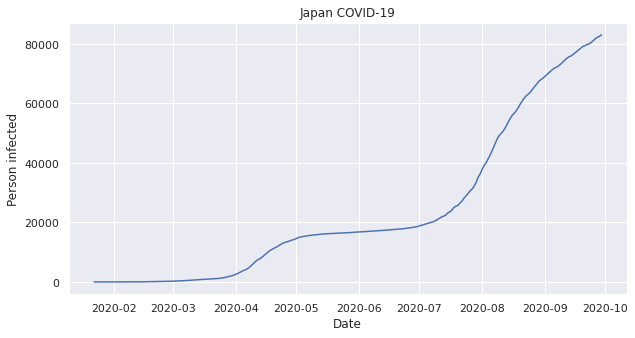

In [6]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date")
plt.ylabel("Person infected")
plt.grid(True)
plt.show()

In [7]:
#ファイル保存
fname ='original.png'
plt.savefig(fname) 
plt.close() 

# residual diff

In [8]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff

2020-01-22      NaN
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
              ...  
2020-09-25    564.0
2020-09-26    649.0
2020-09-27    483.0
2020-09-28    298.0
2020-09-29    538.0
Name: 151, Length: 252, dtype: float64

In [9]:
data_at_japan_diff = data_at_japan_diff.dropna()

In [10]:
data_at_japan_diff

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-09-25    564.0
2020-09-26    649.0
2020-09-27    483.0
2020-09-28    298.0
2020-09-29    538.0
Name: 151, Length: 251, dtype: float64

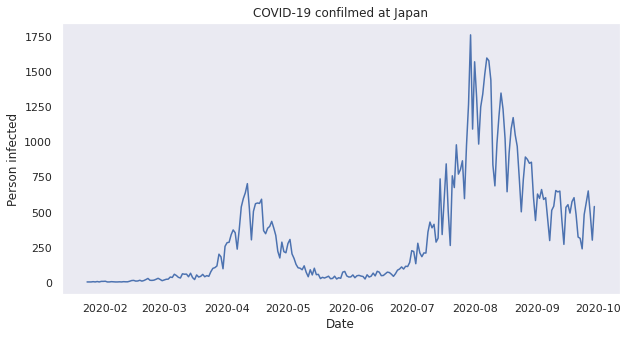

In [11]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel('Date')
plt.ylabel('Person infected')
plt.grid()
plt.show()

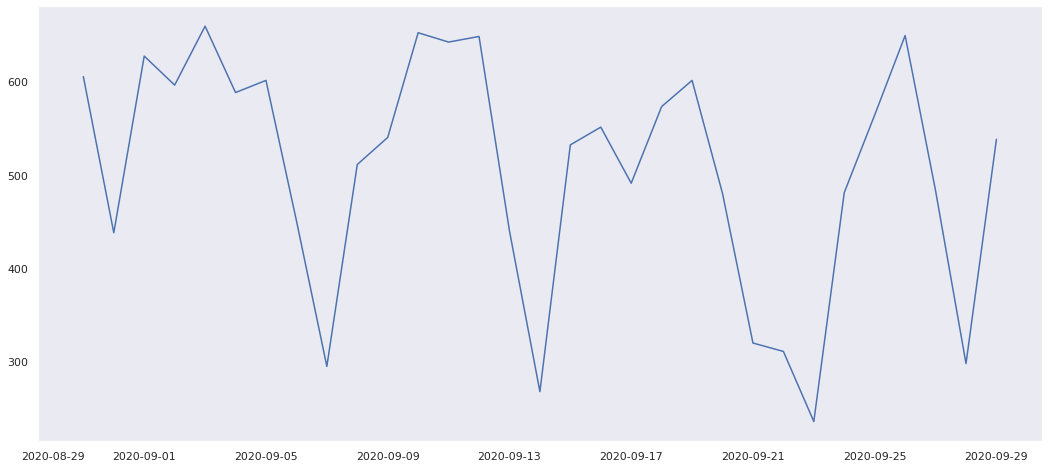

In [12]:
hoge=data_at_japan_diff[-31:]
#print(hoge)
plt.figure(figsize=(18,8))
plt.plot(hoge)
plt.grid()
plt.show()

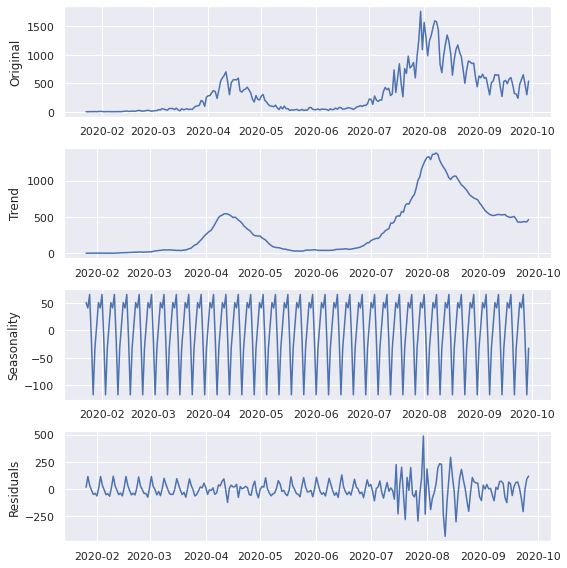

In [13]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [14]:
y = data_at_japan_diff.values.astype(float)

In [15]:
len(y)

251

In [16]:
test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

In [17]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

In [18]:
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

In [19]:
window = 7#学習時のウィンドウサイズ

In [20]:
study_data, correct_data  = sequence_creator(train_normalized, window)

In [21]:
n_out = 1
n_hidden = 256#2の乗数 #256 #512

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, window, n_out), recurrent_activation='sigmoid',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_hidden, recurrent_activation='sigmoid',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_hidden, recurrent_activation='sigmoid',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_out))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["acc"])# optimizer="rmsprop"
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            264192    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [23]:
n2_hidden = 32#2の乗数 #256 #512

model2 = Sequential()
model2.add(LSTM(n2_hidden, batch_input_shape=(None, window, n_out), recurrent_activation='sigmoid',return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(n2_hidden, recurrent_activation='sigmoid',return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(n2_hidden, recurrent_activation='sigmoid',return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(n_out))
model2.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model2.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["acc"])# optimizer="rmsprop"
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 32)             4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [24]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
epochs=200#200
history = model.fit(study_data, correct_data, batch_size=1, epochs=epochs, validation_split=0.1, verbose=1)

Epoch 1/200
213/213 [==============================] - 8s 36ms/step - loss: 0.0654 - acc: 0.0000e+00 - val_loss: 0.0241 - val_acc: 0.0000e+00
Epoch 2/200
213/213 [==============================] - 7s 34ms/step - loss: 0.0448 - acc: 0.0000e+00 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 3/200
213/213 [==============================] - 7s 32ms/step - loss: 0.0467 - acc: 0.0000e+00 - val_loss: 0.0413 - val_acc: 0.0000e+00
Epoch 4/200
213/213 [==============================] - 7s 32ms/step - loss: 0.0417 - acc: 0.0000e+00 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 5/200
213/213 [==============================] - 7s 32ms/step - loss: 0.0447 - acc: 0.0000e+00 - val_loss: 0.0424 - val_acc: 0.0000e+00
Epoch 6/200
213/213 [==============================] - 7s 32ms/step - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0316 - val_acc: 0.0000e+00
Epoch 7/200
213/213 [==============================] - 7s 31ms/step - loss: 0.0358 - acc: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 

In [26]:
epochs=200#200
history2 = model2.fit(study_data, correct_data, batch_size=1, epochs=epochs, validation_split=0.1, verbose=1)

Epoch 1/200
213/213 [==============================] - 3s 13ms/step - loss: 0.0886 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 2/200
213/213 [==============================] - 1s 7ms/step - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0391 - val_acc: 0.0000e+00
Epoch 3/200
213/213 [==============================] - 1s 7ms/step - loss: 0.0396 - acc: 0.0000e+00 - val_loss: 0.0375 - val_acc: 0.0000e+00
Epoch 4/200
213/213 [==============================] - 1s 7ms/step - loss: 0.0444 - acc: 0.0000e+00 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 5/200
213/213 [==============================] - 1s 7ms/step - loss: 0.0397 - acc: 0.0000e+00 - val_loss: 0.0275 - val_acc: 0.0000e+00
Epoch 6/200
213/213 [==============================] - 2s 8ms/step - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0311 - val_acc: 0.0000e+00
Epoch 7/200
213/213 [==============================] - 2s 8ms/step - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 8/200


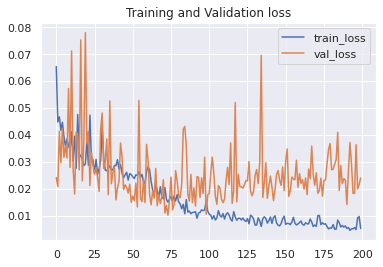

In [27]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

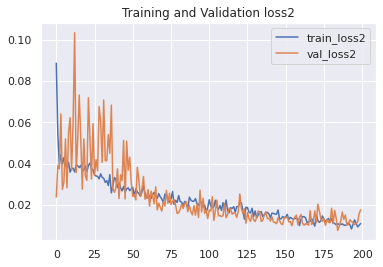

In [29]:
# === 学習推移の可視化 ===
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.plot(np.arange(len(train_loss2)), train_loss2, label="train_loss2")
plt.plot(np.arange(len(val_loss2)), val_loss2, label="val_loss2")
plt.title('Training and Validation loss2')
plt.legend()
plt.show()

In [30]:
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

In [32]:
predicted_past_data2 = model2.predict(study_data)
train_inverse2= scaler.inverse_transform(predicted_past_data2)

In [38]:
datetime = dt.datetime.now()
today = f'{datetime.year}-{datetime.month-1}-{datetime.day}'
today = pd.to_datetime(today)
print(today)

2020-09-01 00:00:00


In [39]:
# the_week_before_last = f'{datetime.year}-{datetime.month}-{datetime.day-21}'
# the_week_before_last= pd.to_datetime(the_week_before_last)
# the_week_before_last

In [33]:
# plt.figure(figsize=(20,8))#サンプル数が多いので通常のpltでは表示がおかしくなるので適当な引数を渡して拡大表示
x0 = np.arange('2020-01-22','2020-09-15', dtype='datetime64[D]').astype('datetime64[D]')
# plt.plot(data_at_japan_diff, label='daily_at_japan')
# plt.plot(x0+7,train_inverse,label='past_predict')
# plt.legend(loc='upper left')

In [34]:
upcoming_future=7

In [35]:
#初期データの作成
predictions = train_normalized[-window:].tolist()
#print("predictions:" + str(predictions))
#print("____________________________________________________________________________")
#Kerasの入力形状を生成
predictions = np.array(predictions).reshape(-1, window, 1)
#print("predictions:")
#print("   ")
#print(predictions)
#print("   ")
#predicted_future = predictions
#print(predicted_future)

In [36]:
#初期データの作成
predictions2 = train_normalized[-window:].tolist()
predictions2 = np.array(predictions2).reshape(-1, window, 1)

In [37]:
#予測をfor文で
for i in range(upcoming_future):
  #print(str(i+1) + "回目のforループ")
  predicted_future = model.predict(predictions)
  #print("predicted_future:" + str(predicted_future) + "    " + "row_predicted_future:"+ str(scaler.inverse_transform(np.array(predicted_future).reshape(-1,1))))
  #print("____________________________________________________________________________")
  predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  #print("predictions:" + str(predictions))
  #print("____________________________________________________________________________")
  predictions = predictions[-window:]
  #print("predictions:" + str(predictions))
  #print("____________________________________________________________________________")
  predictions = np.array(predictions).reshape(-1, window, 1)
  #print("predictions:")
  #print("   ")
  #print(predictions)
  #print("   ")
  #if(i != window-1):
    #print("____________________________________________________________________________")

In [38]:
#予測をfor文で
for i in range(upcoming_future):
  predicted_future2 = model2.predict(predictions2)
  predictions2 = predictions2.tolist()
  predictions2 = np.append(predictions2,predicted_future2)
  predictions2 = predictions2[-window:]
  predictions2 = np.array(predictions2).reshape(-1, window, 1)

In [39]:
predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions_infected_pepole

array([[341.13054979],
       [244.27924526],
       [213.32433796],
       [223.62833971],
       [181.5369103 ],
       [138.91810596],
       [105.84256649]])

In [40]:
predictions_infected_pepole2 = scaler.inverse_transform(np.array(predictions2).reshape(-1,1))
predictions_infected_pepole2

array([[379.45368767],
       [330.61760402],
       [312.24176753],
       [322.25816274],
       [322.0720613 ],
       [311.93142343],
       [319.74946916]])

In [41]:
# lastweek = f'{datetime.year}-{datetime.month}-{datetime.day-7}'
# lastweek= pd.to_datetime(lastweek)
# lastweek

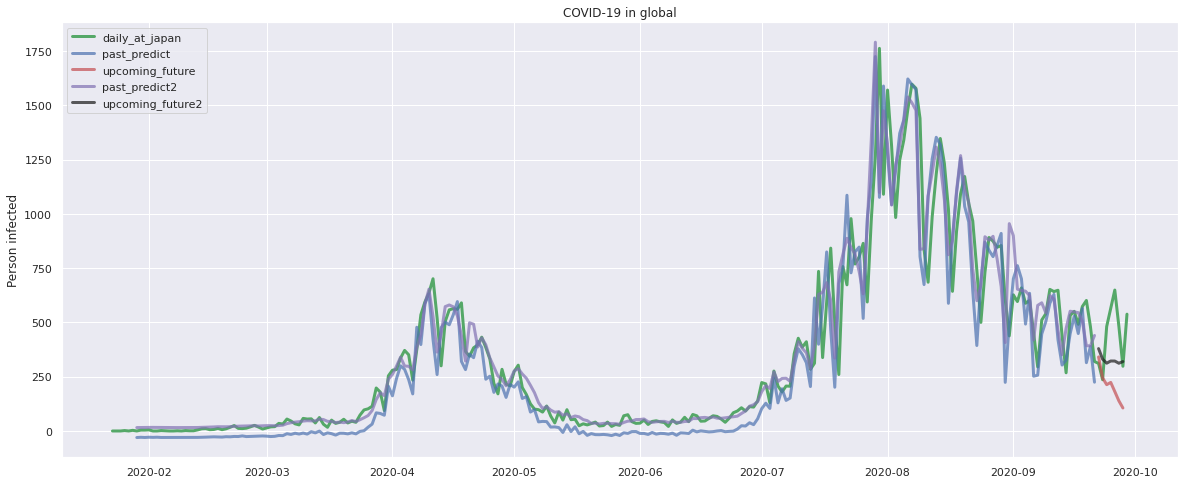

In [46]:
x = np.arange('2020-09-24', '2020-10-01', dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in global")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(data_at_japan_diff,'g',lw=3,label='daily_at_japan')
plt.plot(x0+7,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x-2, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')

plt.plot(x0+7,train_inverse2,color='m', ls='-',lw=3,alpha=0.7, label='past_predict2')
plt.plot(x-2, predictions_infected_pepole2, 'k',lw=3,alpha=0.7,label='upcoming_future2')

plt.legend(loc='upper left')
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score
train_data = train_original_data[7:]
train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))
print('')
print('test_mae:'+str(test_mae))
print('test_mae:'+str(test_mse))
print('test_mae:'+str(test_rmse))
print('test_mae:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:61.14777560576105
train_mse:5840.946003132716
train_rmae:76.42608195591814
train_r2:0.9618818088599035

test_mae:287.2287205883435
test_mae:96278.67262221618
test_mae:310.2880478236572
test_mae:-4.188592354997595


In [44]:
train_mae2 = mean_absolute_error(train_data, train_inverse2)
train_mse2 = mean_squared_error(train_data, train_inverse2)
train_rmse2 = np.sqrt(mean_squared_error(train_data, train_inverse2))
train_r22 = r2_score(train_data, train_inverse2)

test_mae2 = mean_absolute_error(test_original_data, predictions_infected_pepole2)
test_mse2 = mean_squared_error(test_original_data, predictions_infected_pepole2)
test_rmse2 = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole2))
test_r22 = r2_score(test_original_data, predictions_infected_pepole2)

print('train_mae2:'+str(train_mae2))
print('train_mse2:'+str(train_mse2))
print('train_rmae2:'+str(train_rmse2))
print('train_r22:'+str(train_r22))
print('')
print('test_mae2:'+str(test_mae2))
print('test_mae2:'+str(test_mse2))
print('test_mae2:'+str(test_rmse2))
print('test_mae2:'+str(test_r22))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae2:43.61222875973343
train_mse2:4651.074830827975
train_rmae2:68.19878907156618
train_r22:0.969646944294074

test_mae2:180.7780066217695
test_mae2:41008.77736971147
test_mae2:202.5062403228885
test_mae2:-1.2100203809746444


In [35]:
train_mae:54.26724812954287
train_mse:5220.259604330312
train_rmae:72.2513640309324
train_r2:0.9659324271629863

test_mae:111.02983080489295
test_mae:15729.053403449221
test_mae:125.41552297642114
test_mae:0.15233930820049812